In [1]:
%matplotlib widget

In [2]:
%load_ext autoreload

In [3]:
import numba
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
import optax
from libertem.api import Context
from libertem.udf.com import CoMUDF, RegressionOptions

In [4]:
%autoreload
from microscope_calibration.common.model import (
    Parameters4DSTEM, Model4DSTEM, Result4DSTEM, PixelYX, CoordXY, identity, rotate, scale, flip_y,
    DescanError
)
from microscope_calibration.util.stem_overfocus_sim import smiley, project
from microscope_calibration.common.stem_overfocus import (
    get_backward_transformation_matrix, get_detector_correction_matrix, correct_frame, project_frame_backwards
)

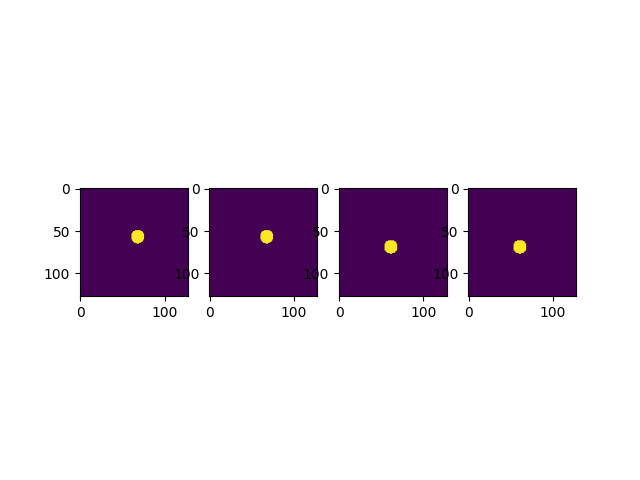

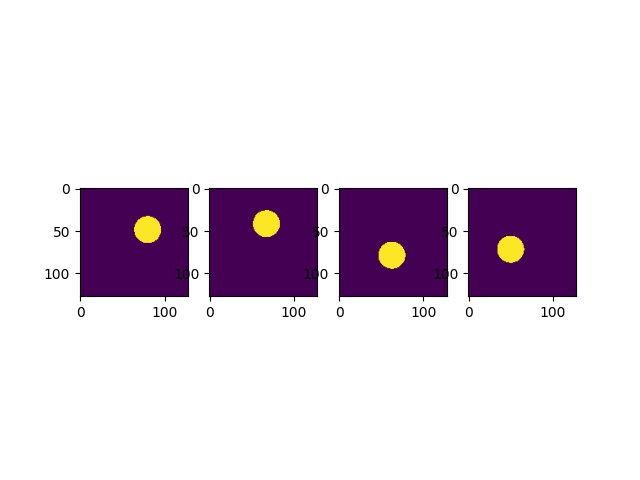

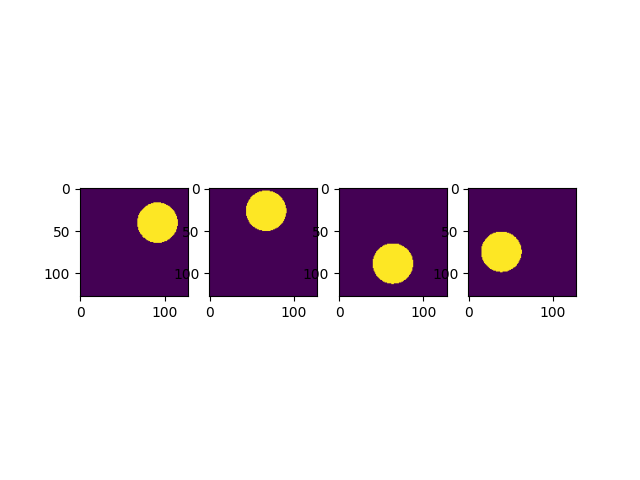

In [5]:
scan_pixel_pitch = 0.1
detector_pixel_pitch = scan_pixel_pitch
overfocus = 0.
camera_length = 1.
propagation_distance = overfocus + camera_length
obj_half_size = 4
angle = np.arctan2(obj_half_size*detector_pixel_pitch/2*4, propagation_distance)

params = Parameters4DSTEM(
    overfocus=overfocus,
    scan_pixel_pitch=scan_pixel_pitch,
    camera_length=camera_length,
    detector_pixel_pitch=detector_pixel_pitch,
    semiconv=angle,
    scan_center=PixelYX(x=obj_half_size, y=obj_half_size),
    scan_rotation=np.pi/2,
    flip_y=True,
    detector_center=PixelYX(x=obj_half_size*16, y=obj_half_size*16),
    detector_rotation=-np.pi*4/3,
    descan_error=DescanError(
        offpxi=detector_pixel_pitch,
        offpyi=2 * detector_pixel_pitch,
        offsxi=-1 * detector_pixel_pitch/camera_length,
        offsyi=-2 * detector_pixel_pitch/camera_length,
        pxo_pxi=1 * detector_pixel_pitch/scan_pixel_pitch,
        pyo_pyi=2 * detector_pixel_pitch/scan_pixel_pitch,
        sxo_pxi=-3 * detector_pixel_pitch/scan_pixel_pitch/camera_length,
        syo_pyi=-2 * detector_pixel_pitch/scan_pixel_pitch/camera_length,
    ),
)

obj = np.ones((2*obj_half_size, 2*obj_half_size))

sims = {}

for cl in (1, 2, 3):
    sims[cl] = project(
        image=obj,
        detector_shape=(32*obj_half_size, 32*obj_half_size),
        scan_shape=(2*obj_half_size, 2*obj_half_size),
        sim_params=params.derive(camera_length=cl),
    )
    fig, axes = plt.subplots(1, 4)
    axes[0].imshow(sims[cl][0, 0])
    axes[1].imshow(sims[cl][0, -1])
    axes[2].imshow(sims[cl][-1, 0])
    axes[3].imshow(sims[cl][-1, -1])

In [6]:
ctx = Context.make_with('inline')
udf = CoMUDF.with_params(
    regression=RegressionOptions.SUBTRACT_LINEAR,
)
regs = {}
for (cl, sim) in sims.items():
    ds = ctx.load('memory', data=sim)
    res = ctx.run_udf(dataset=ds, udf=udf)
    regs[cl] = res['regression'].raw_data

In [7]:
regs

{1: array([[-6.90956137e+00,  3.98811224e+00],
        [ 1.72807100e+00, -9.98795107e-01],
        [ 9.76800977e-04,  4.98367845e-06]]),
 2: array([[-15.18492459,  15.69053952],
        [  4.33269717,  -2.49978101],
        [ -1.00209797,  -1.73023201]]),
 3: array([[-23.44737689,  27.38049086],
        [  6.93250047,  -4.00068786],
        [ -1.99941691,  -3.45880991]])}

In [8]:
exact_regs = {}
for cl in sims.keys():
    exact_params = params.derive(
        camera_length=cl
    )
    model_0 = Model4DSTEM.build(params=exact_params, scan_pos=PixelYX(0, 0))
    ray = model_0.make_source_ray(source_dy=0, source_dx=0).ray
    res_0 = model_0.trace(ray)
    model_y = Model4DSTEM.build(params=exact_params, scan_pos=PixelYX(y=1., x=0.))
    res_y = model_y.trace(ray)
    model_x = Model4DSTEM.build(params=exact_params, scan_pos=PixelYX(y=0., x=1.))
    res_x = model_x.trace(ray)
    dy = res_0['detector'].sampling['detector_px'].y - exact_params.detector_center.y
    dx = res_0['detector'].sampling['detector_px'].x - exact_params.detector_center.x
    
    dydy = res_y['detector'].sampling['detector_px'].y - res_0['detector'].sampling['detector_px'].y
    dxdy = res_y['detector'].sampling['detector_px'].x - res_0['detector'].sampling['detector_px'].x
    dydx = res_x['detector'].sampling['detector_px'].y - res_0['detector'].sampling['detector_px'].y
    dxdx = res_x['detector'].sampling['detector_px'].x - res_0['detector'].sampling['detector_px'].x
    
    reg = np.array((
        (dy, dx),
        (dydy, dxdy),
        (dydx, dxdx)
    ))
    exact_regs[cl] = reg
exact_regs

{1: array([[-6.92820323,  4.        ],
        [ 1.73205081, -1.        ],
        [ 0.        ,  0.        ]]),
 2: array([[-15.18653348,  15.69615242],
        [  4.33012702,  -2.5       ],
        [ -1.        ,  -1.73205081]]),
 3: array([[-23.44486373,  27.39230485],
        [  6.92820323,  -4.        ],
        [ -2.        ,  -3.46410162]])}

In [9]:
for cl in sims.keys():
    print(np.allclose(regs[cl], exact_regs[cl], rtol=1e-2, atol=1e-2))

True
True
True


In [18]:
%autoreload
from microscope_calibration.util.optimize import solve_full_descan_error
res, residual = solve_full_descan_error(
    ref_params=params,
    regressions=exact_regs,
)


In [17]:
np.array(res.descan_error), np.array(params.descan_error)

(array([ 1.73205081,  0.5       ,  1.        , -0.8660254 , -1.73205081,
        -1.5       , -1.        ,  2.59807621,  0.12320508,  0.18660254,
        -0.12320508, -0.18660254]),
 array([ 1. ,  0. ,  0. ,  2. , -3. ,  0. ,  0. , -2. ,  0.1,  0.2, -0.1,
        -0.2]))

In [35]:
# Align coordinate system directions with native CoM coordinate
# system without corrections
ref_params = params.derive(
    flip_y=False,
    scan_rotation=0.,
    detector_rotation=0.,
)
@jax.jit
def loss(optargs, args=None):
    de = DescanError(*optargs)
    distances = []
    for cl, reg in exact_regs.items():
        opt_params = ref_params.derive(
            camera_length=cl,
            descan_error=de,
        )
        for scan_y in (0., 1.):
            for scan_x in (0., 1.):
                dy = reg[0, 0]
                dx = reg[0, 1]
                dydy = reg[1, 0]
                dxdy = reg[1, 1]
                dydx = reg[2, 0]
                dxdx = reg[2, 1]
                det_y = opt_params.detector_center.y + (dy + dydy*scan_y + dydx*scan_x)
                det_x = opt_params.detector_center.x + (dx + dxdy*scan_y + dxdx*scan_x)
                model = Model4DSTEM.build(
                    params=opt_params,
                    scan_pos=PixelYX(y=scan_y, x=scan_x)
                )
                ray = model.make_source_ray(source_dy=0., source_dx=0.).ray
                res = model.trace(ray)
                distances.append((
                    det_y - res['detector'].sampling['detector_px'].y,
                    det_x - res['detector'].sampling['detector_px'].x,
                ))
    return jnp.linalg.norm(jnp.array(distances))
                

In [36]:
loss(jnp.full(shape=(len(DescanError()), ), fill_value=1e-6))

Array(76.01315599, dtype=float64)

In [37]:
import optimistix

In [38]:
%%time
res = optimistix.minimise(fn=loss, solver=optimistix.BFGS(rtol=1e-12, atol=1e-12), y0=jnp.full(shape=(len(DescanError()), ), fill_value=1e-6), max_steps=2**31)
print(res.value)

[ 1.73205081  0.5         1.         -0.8660254  -1.73205081 -1.5
 -1.          2.59807621  0.12320508  0.18660254 -0.12320508 -0.18660254]
CPU times: user 1.46 s, sys: 443 ms, total: 1.9 s
Wall time: 1.32 s


In [46]:
res_params = ref_params.derive(
    descan_error=DescanError(*res.value)
).adjust_scan_rotation(
    params.scan_rotation
).adjust_detector_rotation(
    params.detector_rotation
).adjust_flip_y(
    params.flip_y
)
res.value, np.array(res_params.descan_error), np.array(ref_params.descan_error), np.array(params.descan_error)

(Array([ 1.73205081,  0.5       ,  1.        , -0.8660254 , -1.73205081,
        -1.5       , -1.        ,  2.59807621,  0.12320508,  0.18660254,
        -0.12320508, -0.18660254], dtype=float64),
 array([ 1.00000000e+00, -1.87481768e-12, -3.89530072e-12,  2.00000000e+00,
        -3.00000000e+00,  7.68813502e-13,  1.60125229e-12, -2.00000000e+00,
         1.00000000e-01,  2.00000000e-01, -1.00000000e-01, -2.00000000e-01]),
 array([ 1. ,  0. ,  0. ,  2. , -3. ,  0. ,  0. , -2. ,  0.1,  0.2, -0.1,
        -0.2]),
 array([ 1. ,  0. ,  0. ,  2. , -3. ,  0. ,  0. , -2. ,  0.1,  0.2, -0.1,
        -0.2]))

In [49]:
np.linspace(-1, 1, 12) % 0.11

array([0.1       , 0.06181818, 0.02363636, 0.09545455, 0.05727273,
       0.01909091, 0.09090909, 0.05272727, 0.01454545, 0.08636364,
       0.04818182, 0.01      ])

In [ ]:
@jax.jit
def loss_lstsq(optargs, _=None):
    de = DescanError(*optargs)
    distances = []
    for cl, reg in exact_regs.items():
        opt_params = ref_params.derive(
            camera_length=cl,
            descan_error=de,
        )
        for scan_y in (0., 1.):
            for scan_x in (0., 1.):
                dy = reg[0, 0]
                dx = reg[0, 1]
                dydy = reg[1, 0]
                dxdy = reg[1, 1]
                dydx = reg[2, 0]
                dxdx = reg[2, 1]
                det_y = opt_params.detector_center.y + (dy + dydy*scan_y + dydx*scan_x)
                det_x = opt_params.detector_center.x + (dx + dxdy*scan_y + dxdx*scan_x)
                model = Model4DSTEM.build(
                    params=opt_params,
                    scan_pos=PixelYX(y=scan_y, x=scan_x)
                )
                ray = model.make_source_ray(source_dy=0., source_dx=0.).ray
                res = model.trace(ray)
                distances.extend((
                    det_y - res['detector'].sampling['detector_px'].y,
                    det_x - res['detector'].sampling['detector_px'].x,
                ))
    return jnp.array(distances)**2 + 1

In [ ]:
%%time
res_lstsq = optimistix.least_squares(loss_lstsq, solver=optimistix.BFGS(rtol=1e-12, atol=1e-12), y0=jnp.full(shape=(len(DescanError()), ), fill_value=1e-6), max_steps=2**16)

In [ ]:
res_lstsq.value, opt_res

In [ ]:
type(res_lstsq)

In [ ]:
def test_loss(optargs, args=None):
    return optargs**2 - 1

In [ ]:
(-1)**False

In [ ]:
optimistix.least_squares(test_loss, solver=optimistix.GaussNewton(rtol=1e-12, atol=1e-12), y0=jnp.zeros(3))

In [50]:
angle = np.arctan2(obj_half_size*detector_pixel_pitch/2*2 + 0.0001, propagation_distance)

In [ ]:
y = jnp.full(shape=(len(DescanError()), ), fill_value=1e-6)
gradient_fn = jax.grad(loss)
hessian = lx.JacobianLinearOperator(gradient_fn, y, tags=lx.positive_semidefinite_tag)
solver = lx.CG(rtol=1e-6, atol=1e-6)
out = lx.linear_solve(hessian, gradient_fn(y, args=None), solver)
minimum = y - out.value

In [ ]:
res_params = ref_params.derive(
    descan_error=DescanError(*opt_res)
).adjust_scan_rotation(
    params.scan_rotation
).adjust_detector_rotation(
    params.detector_rotation
).adjust_flip_y(
    params.flip_y
)
print(np.array(params.descan_error) - np.array(res_params.descan_error))

In [ ]:
%autoreload
from microscope_calibration.util.optimize import solve_camera_length
# Determine camera length from a known diffraction angle in radians,
# corresponding detector pixel offset, and detector pixel pitch
scan_pixel_pitch = 0.1
detector_pixel_pitch = 0.2
overfocus = 0.01
camera_length = 1.234
propagation_distance = overfocus + camera_length
obj_half_size = 16
# This is known, e.g. from crystal structure, diffraction order and
# wavelength
angle = np.arctan2(obj_half_size*detector_pixel_pitch/2 + 0.00314157, propagation_distance)
params = Parameters4DSTEM(
    overfocus=overfocus,
    scan_pixel_pitch=scan_pixel_pitch,
    camera_length=camera_length,
    detector_pixel_pitch=detector_pixel_pitch,
    semiconv=angle,
    scan_center=PixelYX(x=obj_half_size, y=obj_half_size),
    scan_rotation=0.,
    flip_y=False,
    detector_center=PixelYX(x=2*obj_half_size, y=2*obj_half_size),
)
# This is observed on the detector
px_radius = jnp.tan(angle) * propagation_distance / detector_pixel_pitch

def doit():
    res, residual = solve_camera_length(
        # Start with a negative value on purpose
        ref_params=params.derive(camera_length=-2*camera_length),
        diffraction_angle=angle,
        radius_px=px_radius,
    )
    return res, residual

%time res, residual = doit()

print(jnp.allclose(res.camera_length, propagation_distance))
print(jnp.allclose(residual, 0., atol=1e-12))

In [53]:
np.arctan2(obj_half_size*detector_pixel_pitch/2*4 + 0.0001, propagation_distance)

np.float64(0.6748019148589584)

In [54]:
mod_params = params.adjust_flip_y(
    flip_y=False,
).adjust_scan_rotation(
    scan_rotation=0.,
).adjust_detector_rotation(
    detector_rotation=0.,
).adjust_detector_rotation(
    detector_rotation=params.detector_rotation
).adjust_scan_rotation(
    scan_rotation=params.scan_rotation,
).adjust_flip_y(
    flip_y=params.flip_y,
)

In [56]:
np.allclose(mod_params.descan_error, params.descan_error)

True